In [1]:
import galarp as grp
import galarp as grp

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala import integrate as gi
from gala import dynamics as gd
from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter


import os

import cProfile

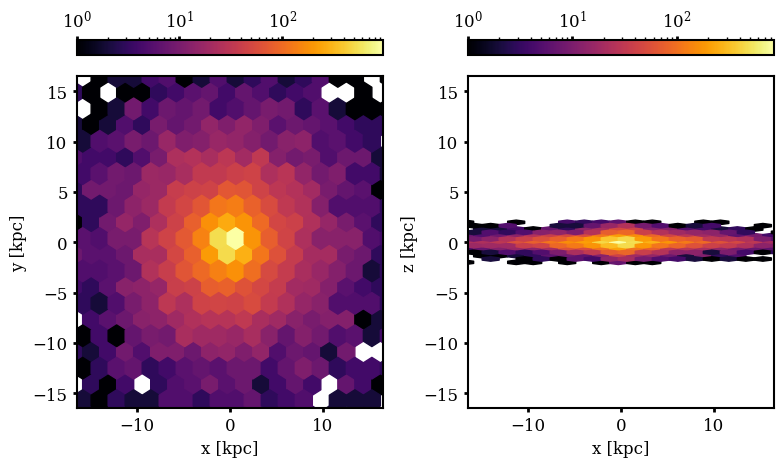

In [2]:
rb2006_satellite = grp.builtins.RB2006_Satellite()

mass_profile = grp.gen_mass_profile(rb2006_satellite)

particles = grp.ParticleSet(particles=grp.ParticleDistribution.from_file("temp/positions_RB.npy"))
particles.generate(mass_profile=mass_profile)
particles.particles.plot_positions(gridsize=30)



In [3]:
wind = grp.builtins.RB2006_Wind(inc=45, peak=800)

shadow = grp.DynamicShadow(wind, radii=np.random.uniform(10, 100, len(particles.particles.x)), 
                           masses=np.random.uniform(10, 100, len(particles.particles.x)),
                           tau_wind=5 * u.Myr,
                           a_disk=10, b_disk=10, n_bins=20,
                           rho=1e-26 * u.g / u.cm ** 3)


# x, y, z, vx, vy, vz = orbits.get_orbit_data(transposed=False)


# index = 40
# xyz = np.array([x[index], y[index], z[index]])
# v_xyz = np.array([vx[index], vy[index], vz[index]])

# shadow.debug_evaluate(xyz.T, v_xyz.T, 100)

In [4]:
def F_RPS_Experimental(
    t, w, potential, shadow, wind, rho, sigma_gas, pressure_multiplier, wind_on=True, debug=False):

    # position units are in kpc, velocity units are in kpc/Myr
    x, y, z, vx, vy, vz = w
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)

    # compute acceleration from potential:
    _t = np.array([0.0])
    acc = -potential._gradient(q, _t).T

    # Compute acceleration from ram pressure
    # a_ram = rho * v_perp^2 / Sigma_cloud
    # TODO remove units altogether
    if wind_on:
        v_perp = wind.evaluate(t) - p
        a_ram = (v_perp**2) * (rho.evaluate(t) / sigma_gas).to(1 / u.kpc).value[:, np.newaxis] * np.sign(v_perp)

        a_ram = a_ram.T

        # If wind is on and shadow exists, apply shadow to appropriate particles
        if shadow is not None:
            shadow = shadow.evaluate(q, p, t).T
            a_ram *= shadow

        acc += a_ram

    # Add central pressure force to prevent crowding in very center
    r = np.sqrt(x**2 + y**2 + z**2)
    acc += pressure_multiplier * q.T / r**3

    return np.vstack((p.T, acc))


# Try adding variable outward forces if size too small


In [5]:


class RPSim:
    def __init__(
        self, wind, potential, shadow=None, potential_name="", method=F_RPS_Experimental):
        self.method = method

        self.wind = wind
        self.potential = potential

        self.shadow = shadow

        self.potential_name = potential_name

        self.sim_results = []

    def run(
        self,
        particles,
        rho_icm=2e-27 * (u.g / u.cm**3),
        t0=100 * u.Myr,
        pressure_multiplier=0.05,
        r_cloud=50 * u.pc, m_cloud=1e5 * u.Msun,
        sigma_gas = 10 * u.Msun / u.pc**2,
        wind_on=True,
        integration_time=500 * u.Myr, dt=5 * u.Myr,
        printout=True,
        wind=None,
        outdir=None,
        debug=False,
    ):

        if type(rho_icm) is u.Quantity:
            self.rho_icm = grp.Density(rho_icm)
        else:
            self.rho_icm = rho_icm

        self.sigma_gas = grp.SigmaGas(sigma=sigma_gas, nparticles=len(particles.container)).sigma
        self.pressure_multiplier = pressure_multiplier

        # Allow for user to switch out wind in the run method
        if wind is not None:
            self.wind = wind

        if printout:
            printout_width = 80
            print("".center(printout_width, "-"))
            print(f" Running GALA sim with  {self.wind.strength:.2e}  wind at  {self.wind.inclination:.2f}  degrees ".center(
                    printout_width, "-"))
            print(f" Running for {integration_time}  at a timestep of  {dt}  ({integration_time / dt:.1f} steps) ".center(
                    printout_width, "-"))
            print("".center(printout_width, "-"))
            print(f" Container contains {len(particles.container)} particles ".center(
                    printout_width, "-"))
            print(f" Each cloud has a mass of  {m_cloud.value:.1e} solar masses  and a radius of  {r_cloud:.2f}   ".center(
                    printout_width, "-"))
            print(f" This corresponds to a density of {(m_cloud / r_cloud **3).to(u.g/u.cm**3):.2e}   ".center(
                    printout_width, "-"))
            print("".center(printout_width, "-"))


        # Set up the function arguments for the given method to calculate the RPS-added acceleration
        if self.method == grp.F_RPS:
            func_args = (self.potential, self.shadow, self.wind, self.rho_icm, r_cloud, m_cloud, wind_on)
        elif self.method == F_RPS_Experimental:
            func_args = (self.potential, self.shadow, self.wind, self.rho_icm, self.sigma_gas, self.pressure_multiplier, wind_on)
        elif self.method == grp.F_RPS_Vollmer:
            func_args = (self.potential, self.shadow, self.wind, self.rho_icm, self.sigma_gas, wind_on)

        print(self.pressure_multiplier)
        integrator = gi.RK5Integrator(
            self.method,
            func_args=func_args,
            func_units=galactic,
            progress=not debug,
        )


        orbits = integrator.run(
            gd.combine(particles.container), dt=dt, t1=0, t2=integration_time
        )
        self.sim_results.append(orbits)

        metadata = {
            "WIND": self.wind,
            "POTENTIAL": self.potential,
            "POTENTIAL_NAME": self.potential_name,
            "SHADOW": self.shadow,
            "RHO_ICM": self.rho_icm,
            "PARTICLE_GRID": particles,
            "R_CLOUD": r_cloud,
            "M_CLOUD": m_cloud,
            "WIND_ON": wind_on,
            "INTEGRATION_TIME": integration_time,
            "DT": dt,
        }

        out = grp.OrbitContainer(orbits, units=galactic, metadata=metadata)

        if outdir is not None:
            os.makedirs(outdir, exist_ok=True)
            grp.save_orbits(out, outdir=outdir)


        return out

    def __repr__(self) -> str:
        return f"Ram Pressure Sim \n Wind: \t\t{self.wind.__repr__()}\n Shadow: \t{self.shadow.__repr__()}\n Potential: \t{self.potential}"



sim = RPSim(wind=wind, potential=rb2006_satellite, shadow=None)

In [6]:
sim = RPSim(wind=wind, potential=rb2006_satellite, shadow=None)

shadow = grp.DynamicShadow(wind, radii=np.random.uniform(10, 100, len(particles.particles.x)), 
                           masses=np.random.uniform(10, 100, len(particles.particles.x)),
                           tau_wind=5 * u.Myr,
                           a_disk=10, b_disk=10, n_bins=20,
                           rho=1e-26 * u.g / u.cm ** 3)

#orbits = sim.run(particles, rho_icm=1e-26 * (u.g / u.cm**3), pressure_multiplier=0.05, dt=2 * u.Myr, integration_time=100 * u.Myr, printout=False)
# %timeit orbits = sim.run(particles, rho_icm=1e-26 * (u.g / u.cm**3), dt=2 * u.Myr, integration_time=100 * u.Myr, printout=False)

#cProfile.run("orbits = sim.run(particles, rho_icm=1e-26 * (u.g / u.cm**3), dt=2 * u.Myr, integration_time=100 * u.Myr, printout=False)", 'profile_output.txt')

orbit_containers = []

for inc in [0, 15, 30, 45, 60, 75, 90]:
    wind = grp.builtins.RB2006_Wind(inc=inc, peak=800)

    shadow = grp.DynamicShadow(wind, radii=np.random.uniform(10, 100, len(particles.particles.x)), 
                            masses=np.random.uniform(10, 100, len(particles.particles.x)),
                            tau_wind=5 * u.Myr,
                            a_disk=10, b_disk=10 / 2, n_bins=20,
                            rho=1e-26 * u.g / u.cm ** 3)
    
    sim = RPSim(wind=wind, potential=rb2006_satellite, shadow=shadow)

    orbits = sim.run(particles, rho_icm=1e-26 * (u.g / u.cm**3),
                      dt=2 * u.Myr, integration_time=1200 * u.Myr, 
                      sigma_gas=20 * u.Msun / u.pc **2, 
                      printout=True, pressure_multiplier=0.05)

    grp.animated_surface_density_plot(orbits, masses=shadow.masses, outname=f"figures/sd_evol/sd_shadow_withpressure_hisigma{inc}.gif", n_frames=100, cmap=cmap)

    orbit_containers.append(orbits)

--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  0.00  degrees -------
------- Running for 1200.0 Myr  at a timestep of  2.0 Myr  (600.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------
0.05


100%|██████████| 599/599 [01:19<00:00,  7.50it/s]


600
--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  0.26  degrees -------
------- Running for 1200.0 Myr  at a timestep of  2.0 Myr  (600.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------
0.05


100%|██████████| 599/599 [01:31<00:00,  6.55it/s]


600
--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  0.52  degrees -------
------- Running for 1200.0 Myr  at a timestep of  2.0 Myr  (600.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------
0.05


100%|██████████| 599/599 [01:36<00:00,  6.23it/s]


600
--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  0.79  degrees -------
------- Running for 1200.0 Myr  at a timestep of  2.0 Myr  (600.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------
0.05


100%|██████████| 599/599 [01:46<00:00,  5.63it/s]


600
--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  1.05  degrees -------
------- Running for 1200.0 Myr  at a timestep of  2.0 Myr  (600.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------
0.05


100%|██████████| 599/599 [01:18<00:00,  7.67it/s]


600
--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  1.31  degrees -------
------- Running for 1200.0 Myr  at a timestep of  2.0 Myr  (600.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------
0.05


100%|██████████| 599/599 [01:23<00:00,  7.19it/s]


600
--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  1.57  degrees -------
------- Running for 1200.0 Myr  at a timestep of  2.0 Myr  (600.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------
0.05


100%|██████████| 599/599 [01:44<00:00,  5.76it/s]


600


In [26]:
incs = [0, 30, 60, 75, 90]

colors = ["black", "indigo", "red", "maroon", "green"]

for i, container in enumerate(orbit_containers):
    times, evol = Mdisk(container, masses=shadow.masses)
    plt.plot(times, evol / 1e9, color=colors[i], lw=2, 
             label=f"i = {incs[i]}, sin(i) = {np.sin(np.deg2rad(incs[i])):.2f}")

NameError: name 'orbit_containers' is not defined

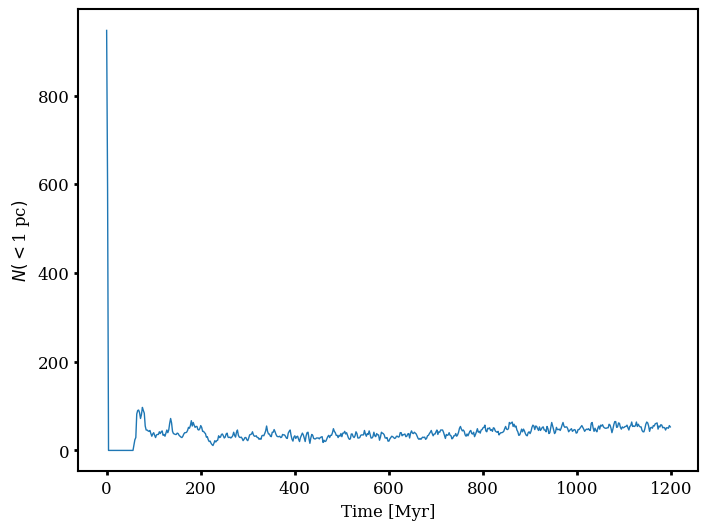

In [25]:
def central_density(orbits, r_min=1):
    x,y,z, *_ = orbits.get_orbit_data(transposed=False)

    r = np.sqrt(x**2 + y**2 + z**2)

    central_n = np.zeros(len(r))
    for i in range(len(r)):
        this_r = r[i]
        central_n[i] = np.sum(this_r < r_min)
    
    plt.figure(figsize=(8, 6))
    plt.plot(orbits.data.t, central_n)
    plt.xlabel("Time [Myr]")
    plt.ylabel(r'$N (< $' + f'{r_min} pc' + r'$)$') 
central_density(orbits)